# Visualize PCA of weight, activity and Estimates MI from data

## Import lib

In [434]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader , TensorDataset
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
import torch.nn.init as init

import numpy as np
import math

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import MultipleLocator
import matplotlib.cm as cm
from matplotlib.ticker import StrMethodFormatter

import copy
import seaborn as sns

from scipy.stats import norm
from sklearn.neighbors import KernelDensity, LocalOutlierFactor
from sklearn.decomposition import PCA

import tqdm

import pickle

# MI estimators
from utils.estimators import *

## Load data

In [435]:
def reshape_to_single(val):
    '''
    Input dim : [timestep , np:[1,dim] ]
    Return dim : np: [timestep , dim]
    '''
    for i in range(len(val)):
        val[i] = val[i].reshape(-1)
    return np.array(val)
def select_activity_layer(activity,selected_layer):
    '''
    Input dim : [timestep][layer]
    Return dim : np: [timestep , dim]
    '''
    buff = []
    for t in range(len(activity)):
        layer = activity[t][selected_layer]
        buff.append(layer.reshape(-1) if isinstance(layer, np.ndarray) else layer.numpy().reshape(-1))
    return np.array(buff , dtype=object)
def select_weight_layer(weight,selected_layer):
    '''
    Input dim : [timestep][layer]
    Return dim : np: [timestep , dim]
    '''
    buff = []
    for t in range(len(weight)):
        _b = weight[t][selected_layer][0]
        buff.append(_b if isinstance(_b, np.ndarray) else _b.numpy())
    return np.array(buff , dtype=object)


In [436]:
import numpy as np
from scipy.spatial.distance import cdist
from scipy.special import psi

def ksg_estimator(X, Y, k):
    N = len(X)
    
    # Combine X and Y into a joint dataset Z
    Z = np.column_stack((X, Y))
    
    # Calculate pairwise distances in the joint space and in the marginal spaces
    dist_Z = cdist(Z, Z, metric='euclidean')
    dist_X = cdist(X, X, metric='euclidean')
    dist_Y = cdist(Y, Y, metric='euclidean')

    # Sort the distances and find the k-th nearest neighbor distances
    dist_Z_sorted = np.sort(dist_Z, axis=1)
    dist_X_sorted = np.sort(dist_X, axis=1)
    dist_Y_sorted = np.sort(dist_Y, axis=1)
    # Get the k-th neighbor distances for joint and marginal spaces
    eps_Z = dist_Z_sorted[:, k]
    eps_X = dist_X_sorted[:, k]
    eps_Y = dist_Y_sorted[:, k]
    eps_max = np.maximum(eps_X, eps_Y)
    
    # Count the number of neighbors within the k-th neighbor distance for X and Y
    nx = np.array([np.sum(dist_X[i] <= eps_max[i]) for i in range(N)])
    ny = np.array([np.sum(dist_Y[i] <= eps_max[i]) for i in range(N)])
    
    # Compute the digamma functions and the final MI estimate
    digamma_k = psi(k)
    digamma_N = psi(N)
    
    # Average over all data points
    avg_digamma_nx_ny = np.mean(psi(nx + 1) + psi(ny + 1))
    
    # MI estimate
    MI = digamma_k - avg_digamma_nx_ny + digamma_N
    return MI

# Example usage with random data
# X = np.random.rand(1000,3)
# Y = np.random.rand(1000,3)
# k = 5  # Number of neighbors

# mi = ksg_estimator(X, Y, k)
# print(f"Estimated MI: {mi}")

In [437]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="" ,cbar=True, **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    if cbar:
        cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
        cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(range(data.shape[1]), labels=col_labels,
                  rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticks(range(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    # ax.tick_params(top=True, bottom=False,
    #                labeltop=True, labelbottom=False)

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [438]:
seed = 2
run = 2

In [439]:
with open(f"data/weight_dynamic/zero-HEBB-FULL_STATE-seed_{seed}-rand_{run}.pkl", "rb") as f:
    loaded_buffer = pickle.load(f)

In [440]:
normal = {}
load = loaded_buffer
activity    = load["brain"]["activity"]              # [timestep][layer_n][ 1 , hidden_dim]
weight      = load["brain"]["weight"]                # [timestep][layer_n][ 1 , 64 , 128]
normal["input"]       = reshape_to_single(load["data"]["state"])           # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]
normal["act_hid_1"]   = select_activity_layer(activity , 0)             # [timestep][layer_n][1 , hidden_dim] ---reshape---> [timestep, num_dim_of_selected_layer]
normal["act_hid_2"]   = select_activity_layer(activity , 1)
normal["weight_hid_1"] = select_weight_layer(weight,0)
normal["weight_hid_2"] = select_weight_layer(weight,1)
normal["weight_hid_3"] = select_weight_layer(weight,2)
normal["output"]      = reshape_to_single(load["data"]["action"])          # [timestep][1 , all_observation] ---reshape---> [timestep, all_obs]

In [441]:
pca = PCA(n_components=5)
hidden_weight = {}
hidden_weight["layer1"] = normal["weight_hid_1"].reshape(normal["weight_hid_1"].shape[0] , -1)
hidden_weight["layer2"] = normal["weight_hid_2"].reshape(normal["weight_hid_2"].shape[0] , -1)
hidden_weight["layer3"] = normal["weight_hid_3"].reshape(normal["weight_hid_3"].shape[0] , -1)

hidden_weight["PCA_layer1"] = pca.fit_transform(hidden_weight["layer1"])
hidden_weight["PCA_layer2"] = pca.fit_transform(hidden_weight["layer2"])
hidden_weight["PCA_layer3"] = pca.fit_transform(hidden_weight["layer3"])

In [442]:
pos_idx = np.arange(0,19)
vel_idx = np.arange(19,19*2)
action_idx = np.arange(19*2,19*3)
IMU_idx = np.arange(57,60)
fc_idx = np.arange(60,64)

normal["input"].shape
num_joint = 19
joint_idx = []
for i in range(num_joint):
    temp = [i , num_joint + i , 2*num_joint +i]
    joint_idx.append(temp)
joint_idx = np.array(joint_idx)

## Estimating Group

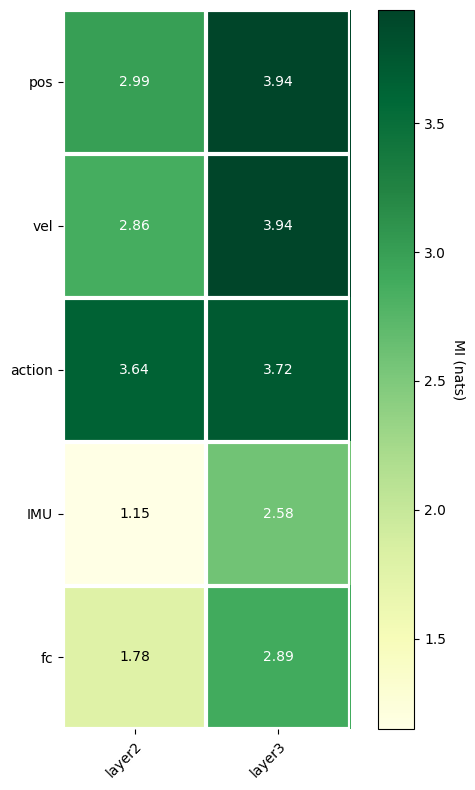

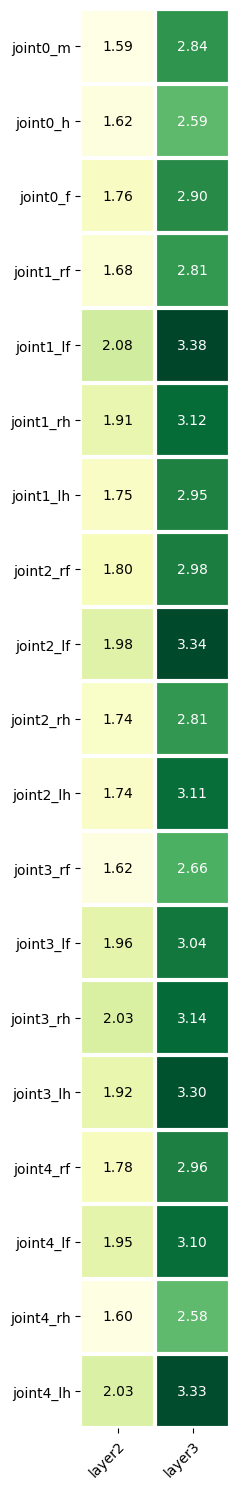

In [443]:
# PCA input sensory
mode = 0
name = f"{mode}_{seed}_{run}"

if mode == 0:
    start_idx = 100
    end_idx = 1100
elif mode == 1:
    start_idx = 1100
    end_idx = 2100

# PCA each sensory
pca1_pos = pca.fit_transform(normal["weight_hid_1"][start_idx:end_idx,pos_idx,:].reshape(normal["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))
pca1_vel = pca.fit_transform(normal["weight_hid_1"][start_idx:end_idx,vel_idx,:].reshape(normal["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))
pca1_action = pca.fit_transform(normal["weight_hid_1"][start_idx:end_idx,action_idx,:].reshape(normal["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))
pca1_IMU = pca.fit_transform(normal["weight_hid_1"][start_idx:end_idx,IMU_idx,:].reshape(normal["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))
pca1_fc = pca.fit_transform(normal["weight_hid_1"][start_idx:end_idx,fc_idx,:].reshape(normal["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))

# PCA hidden layer
normal_pca_hid2 = pca.fit_transform(normal["weight_hid_2"][start_idx:end_idx,:,:].reshape(normal["weight_hid_2"][start_idx:end_idx,:,:].shape[0] , -1))
normal_pca_hid3 = pca.fit_transform(normal["weight_hid_3"][start_idx:end_idx,:,:].reshape(normal["weight_hid_3"][start_idx:end_idx,:,:].shape[0] , -1))

# Estiamte MI each sensory to hidden layer
sensory1_mi = np.zeros((5,2))  # First index: layer 2,3 ,second index : joint index
sensory_pca = [pca1_pos , pca1_vel , pca1_action , pca1_IMU , pca1_fc]
for index , sensory in enumerate(sensory_pca):
    sensory1_mi[index,0] = ksg_estimator(sensory , normal_pca_hid2 , 5)
    sensory1_mi[index,1] = ksg_estimator(sensory , normal_pca_hid3 , 5)

# Estiamte MI each joint to hidden layer
normal_mi = np.zeros((19,2))  # First index: layer 2,3 ,second index : joint index
normal_pca = []
# PCA each joint
for i,joint in enumerate(joint_idx):
    temp = pca.fit_transform(normal["weight_hid_1"][start_idx:end_idx,joint,:].reshape(normal["weight_hid_1"][start_idx:end_idx,joint,:].shape[0] , -1))
    normal_pca.append(temp)
    del temp
normal_pca = np.array(normal_pca)
for index , joint in enumerate(joint_idx):
    normal_mi[index,0] = ksg_estimator(normal_pca[index] , normal_pca_hid2 , 5)
    normal_mi[index,1] = ksg_estimator(normal_pca[index] , normal_pca_hid3 , 5)

# Plot heatmap
# Sensory
fig, ax = plt.subplots(1, 1, figsize=(6, 8))
im , cbar = heatmap(sensory1_mi, row_labels=['pos', 'vel', 'action', 'IMU', 'fc'], col_labels=['layer2', 'layer3'], cbarlabel="MI (nats)", cmap="YlGn" , cbar=True)
_ = annotate_heatmap(im=im , valfmt="{x:.2f}")
fig.tight_layout()
fig.savefig(f'figures/sensory_mi_{name}.png')

# Joint
label = ['joint0_m', 'joint0_h', 'joint0_f', 'joint1_rf', 'joint1_lf', 'joint1_rh', 'joint1_lh', 'joint2_rf', 'joint2_lf', 'joint2_rh', 'joint2_lh', 'joint3_rf', 'joint3_lf', 'joint3_rh', 'joint3_lh', 'joint4_rf', 'joint4_lf', 'joint4_rh', 'joint4_lh']
fig, ax = plt.subplots(1, 1, figsize=(4, 15))
im , cbar = heatmap(normal_mi, row_labels=label, col_labels=["layer2" , "layer3"], cbarlabel="MI (nats)", cmap="YlGn" , cbar=False , ax=ax)
_ = annotate_heatmap(im=im , valfmt="{x:.2f}")
fig.tight_layout()
fig.savefig(f'figures/joint_mi_{name}.png')

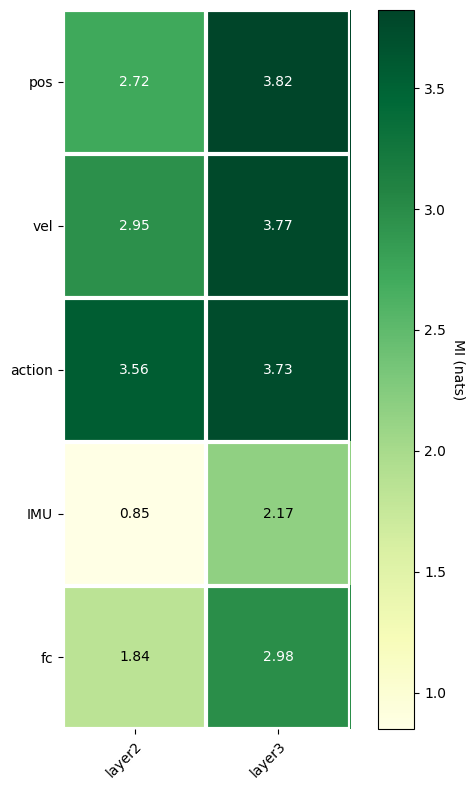

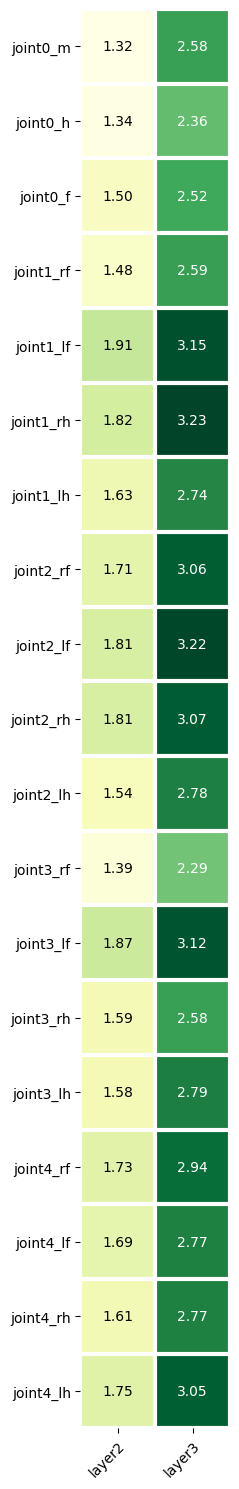

In [444]:
# PCA input sensory
mode = 1
name = f"{mode}_{seed}_{run}"

if mode == 0:
    start_idx = 100
    end_idx = 1100
elif mode == 1:
    start_idx = 1100
    end_idx = 2100

# PCA each sensory
pca1_pos = pca.fit_transform(normal["weight_hid_1"][start_idx:end_idx,pos_idx,:].reshape(normal["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))
pca1_vel = pca.fit_transform(normal["weight_hid_1"][start_idx:end_idx,vel_idx,:].reshape(normal["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))
pca1_action = pca.fit_transform(normal["weight_hid_1"][start_idx:end_idx,action_idx,:].reshape(normal["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))
pca1_IMU = pca.fit_transform(normal["weight_hid_1"][start_idx:end_idx,IMU_idx,:].reshape(normal["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))
pca1_fc = pca.fit_transform(normal["weight_hid_1"][start_idx:end_idx,fc_idx,:].reshape(normal["weight_hid_1"][start_idx:end_idx,pos_idx,:].shape[0] , -1))

# PCA hidden layer
normal_pca_hid2 = pca.fit_transform(normal["weight_hid_2"][start_idx:end_idx,:,:].reshape(normal["weight_hid_2"][start_idx:end_idx,:,:].shape[0] , -1))
normal_pca_hid3 = pca.fit_transform(normal["weight_hid_3"][start_idx:end_idx,:,:].reshape(normal["weight_hid_3"][start_idx:end_idx,:,:].shape[0] , -1))

# Estiamte MI each sensory to hidden layer
sensory1_mi = np.zeros((5,2))  # First index: layer 2,3 ,second index : joint index
sensory_pca = [pca1_pos , pca1_vel , pca1_action , pca1_IMU , pca1_fc]
for index , sensory in enumerate(sensory_pca):
    sensory1_mi[index,0] = ksg_estimator(sensory , normal_pca_hid2 , 5)
    sensory1_mi[index,1] = ksg_estimator(sensory , normal_pca_hid3 , 5)

# Estiamte MI each joint to hidden layer
normal_mi = np.zeros((19,2))  # First index: layer 2,3 ,second index : joint index
normal_pca = []
# PCA each joint
for i,joint in enumerate(joint_idx):
    temp = pca.fit_transform(normal["weight_hid_1"][start_idx:end_idx,joint,:].reshape(normal["weight_hid_1"][start_idx:end_idx,joint,:].shape[0] , -1))
    normal_pca.append(temp)
    del temp
normal_pca = np.array(normal_pca)
for index , joint in enumerate(joint_idx):
    normal_mi[index,0] = ksg_estimator(normal_pca[index] , normal_pca_hid2 , 5)
    normal_mi[index,1] = ksg_estimator(normal_pca[index] , normal_pca_hid3 , 5)

# Plot heatmap
# Sensory
fig, ax = plt.subplots(1, 1, figsize=(6, 8))
im , cbar = heatmap(sensory1_mi, row_labels=['pos', 'vel', 'action', 'IMU', 'fc'], col_labels=['layer2', 'layer3'], cbarlabel="MI (nats)", cmap="YlGn" , cbar=True)
_ = annotate_heatmap(im=im , valfmt="{x:.2f}")
fig.tight_layout()
fig.savefig(f'figures/sensory_mi_{name}.png')

# Joint
label = ['joint0_m', 'joint0_h', 'joint0_f', 'joint1_rf', 'joint1_lf', 'joint1_rh', 'joint1_lh', 'joint2_rf', 'joint2_lf', 'joint2_rh', 'joint2_lh', 'joint3_rf', 'joint3_lf', 'joint3_rh', 'joint3_lh', 'joint4_rf', 'joint4_lf', 'joint4_rh', 'joint4_lh']
fig, ax = plt.subplots(1, 1, figsize=(4, 15))
im , cbar = heatmap(normal_mi, row_labels=label, col_labels=["layer2" , "layer3"], cbarlabel="MI (nats)", cmap="YlGn" , cbar=False , ax=ax)
_ = annotate_heatmap(im=im , valfmt="{x:.2f}")
fig.tight_layout()
fig.savefig(f'figures/joint_mi_{name}.png')